# How to combine control flow and state updates with Command
https://langchain-ai.github.io/langgraph/how-tos/command/

> It can be useful to combine control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node. LangGraph provides a way to do so by returning a Command object from node functions

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        # state update
        update={"foo": "bar"},
        # control flow
        goto="my_other_node"
    )
```

> If you are using subgraphs, you might want to navigate from a node a subgraph to a different subgraph (i.e. a different node in the parent graph)

```python
def my_node(state: State) -> Command[Literal["my_other_node"]]:
    return Command(
        update={"foo": "bar"},
        goto="other_subgraph",  # where `other_subgraph` is a node in the parent graph
        graph=Command.PARENT
    )
```

## Basic usage

In [1]:
import random
from typing_extensions import TypedDict, Literal

from langgraph.graph import StateGraph, START
from langgraph.types import Command


# Define graph state
class State(TypedDict):
    foo: str


# Define the nodes


def node_a(state: State) -> Command[Literal["node_b", "node_c"]]:
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )


def node_b(state: State):
    print("Called B")
    return {"foo": state["foo"] + "b"}


def node_c(state: State):
    print("Called C")
    return {"foo": state["foo"] + "c"}

In [7]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(node_b)
builder.add_node(node_c)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

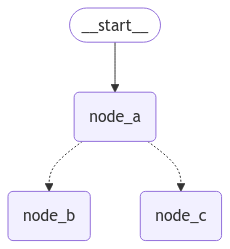

In [8]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"foo": ""})

Called A
Called B


{'foo': 'ab'}

## Navigating to a node in a parent graph

In [13]:
import operator
from typing_extensions import Annotated


class State(TypedDict):
    # NOTE: we define a reducer here
    foo: Annotated[str, operator.add]


def node_a(state: State):
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"foo": value},
        goto=goto,
        # this tells LangGraph to navigate to node_b or node_c in the parent graph
        # NOTE: this will navigate to the closest parent graph relative to the subgraph
        graph=Command.PARENT,
    )


subgraph = StateGraph(State).add_node(node_a).add_edge(START, "node_a").compile()


def node_b(state: State):
    print("Called B")
    # NOTE: since we've defined a reducer, we don't need to manually append
    # new characters to existing 'foo' value. instead, reducer will append these
    # automatically (via operator.add)
    return {"foo": "b"}


def node_c(state: State):
    print("Called C")
    return {"foo": "c"}

In [17]:
graph.invoke({"foo": ""})

Called A
Called B


{'foo': 'ab'}

In [19]:
builder = StateGraph(State)
builder.add_edge(START, "subgraph")
builder.add_node("subgraph", subgraph)
builder.add_node(node_b)
builder.add_node(node_c)

graph = builder.compile()


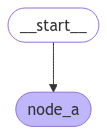

In [20]:
from IPython.display import display, Image

display(Image(subgraph.get_graph().draw_mermaid_png()))

In [21]:
from IPython.display import display, Image

# cannot display the graph directly, as it contains a subgraph
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to render the graph using the Mermaid.INK API. Status code: 400.